## Environment setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!unzip /content/drive/MyDrive/projects/blood_cancer_detr/dataset/train-20240110T041203Z-001.zip -d /content/drive/MyDrive/projects/blood_cancer_detr/dataset

In [ ]:
!pip install -i https://test.pypi.org/simple/ supervision==0.3.1
!pip install -q -U transformers
!pip install -q -U pytorch-lightning
!pip install -q  -U  timm

Looking in indexes: https://test.pypi.org/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.7 MB/s eta 0:00:00


# Imports

In [ ]:
#import some necessary librairies
import os
import random
import os.path
from pathlib import Path
import warnings
import itertools
from warnings import filterwarnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore all warning  message from librairies

# linear algebra
import numpy as np
# data processing
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import transformers
import pytorch_lightning
import os
import timm
from transformers import DetrConfig, DetrForObjectDetection,DetrFeatureExtractor#,DetrTimmConvEncoderوDetrImageProcessor
import torchvision
import cv2
import supervision as sv
import pytorch_lightning as pl
from transformers import DetrForObjectDetection
import torch
from torch.nn import CrossEntropyLoss

!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)


print(
    "; supervision:", sv.__version__,
    "; transformers:", transformers.__version__,
    "; pytorch_lightning:", pytorch_lightning.__version__
)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.1 ; cuda:  cu121
; supervision: 0.3.1 ; transformers: 4.36.2 ; pytorch_lightning: 2.1.3


# Constants

In [ ]:
import os
import torch

PROJECT_NAME = "" #just for project title
RANDOM_SEED = 42

MAIN_PROJECT_PATH = "/content/drive/MyDrive/projects/blood_cancer_project"
DATASET_PATH= "/content/drive/MyDrive/projects/blood_cancer_detr/dataset"

#DETR Config
MODEL_TRAIN_EPOCHS = 100
NUM_OF_CLASS = 2
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_NAMEL="detr_backbone_seresnet_model"
CHECKPOINT = 'facebook/detr-resnet-50'
BACKBONE="seresnet50"
CONFIDENCE_TRESHOLD = 0.75
IOU_TRESHOLD = 0.8


In [ ]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(RANDOM_SEED)

### Setup some configs

In [ ]:
%matplotlib inline
sns.set_theme()

### Setup Image Preprocessor

In [ ]:
from transformers import DetrImageProcessor
image_processor = DetrImageProcessor.from_pretrained(CHECKPOINT)

preprocessor_config.json:   0%|          | 0.00/274 [00:00<?, ?B/s]

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


## Create COCO data loaders

In [ ]:
# settings
ANNOTATION_FILE_NAME = "annotations.json"
TRAIN_DIRECTORY = os.path.join(DATASET_PATH, "train")
VAL_DIRECTORY = os.path.join(DATASET_PATH, "val")


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(
        self,
        image_directory_path: str,
        image_processor,
        train: bool = True
    ):
        annotation_file_path = os.path.join(image_directory_path, ANNOTATION_FILE_NAME)
        super(CocoDetection, self).__init__(image_directory_path, annotation_file_path)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        images, annotations = super(CocoDetection, self).__getitem__(idx)
        image_id = self.ids[idx]
        annotations = {'image_id': image_id, 'annotations': annotations}
        encoding = self.image_processor(images=images, annotations=annotations, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return pixel_values, target


TRAIN_DATASET = CocoDetection(
    image_directory_path=TRAIN_DIRECTORY,
    image_processor=image_processor,
    train=True)
VAL_DATASET = CocoDetection(
    image_directory_path=VAL_DIRECTORY,
    image_processor=image_processor,
    train=False)

print("Number of training examples:", len(TRAIN_DATASET))
print("Number of validation examples:", len(VAL_DATASET))

loading annotations into memory...
Done (t=0.99s)
creating index...
index created!
loading annotations into memory...
Done (t=0.33s)
creating index...
index created!
Number of training examples: 62
Number of validation examples: 9


## Visualize and Display Some Samples from  Dataset

In [ ]:
categories = TRAIN_DATASET.coco.cats
DATASET_LABELS = {k: v['name'] for k,v in categories.items()}
DATASET_LABELS

{1: 'LAL', 2: 'LAM'}

In [ ]:
# select random image
image_ids = TRAIN_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

Image #41


In [ ]:
def get_image_with_annotation(img,annot):
  image_path = os.path.join(TRAIN_DATASET.root, img['file_name'])
  image = cv2.imread(image_path)


  # annotate
  detections = sv.Detections.from_coco_annotations(coco_annotation=annot)

  # we will use id2label function for training

  labels = [
      f"{DATASET_LABELS[class_id]}"
      for _, _, class_id, _
      in detections
  ]

  box_annotator = sv.BoxAnnotator()
  frame = box_annotator.annotate(scene=image, detections=detections, labels=labels)
  return frame


<Figure size 800x800 with 0 Axes>

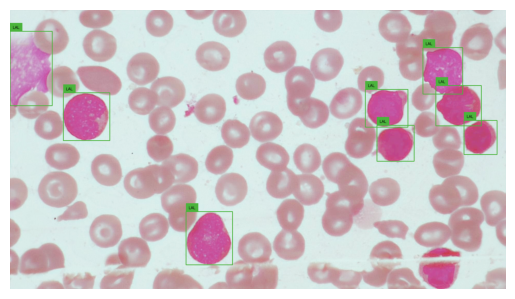

In [ ]:
# load image and annotatons
image = TRAIN_DATASET.coco.loadImgs(image_id)[0]
annotations = TRAIN_DATASET.coco.imgToAnns[image_id]
img = get_image_with_annotation(image,annotations)
%matplotlib inline
#sv.show_frame_in_notebook(image, (16, 16))

plt.figure(figsize=(8,8))
fig , ax  = plt.subplots( )
ax.axis("off")
ax.imshow(img)

In [ ]:
image

{'id': 41,
 'width': 1920,
 'height': 1080,
 'file_name': '6924LALT4.jpeg',
 'license': 0,
 'flickr_url': '',
 'coco_url': '',
 'date_captured': 0}

In [ ]:
fig, axes = plt.subplots(nrows=3,
                         ncols=3,
                         figsize=(18, 12),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat ):
    image_id = random.choice(image_ids)
    image = TRAIN_DATASET.coco.loadImgs(image_id)[0]
    annotations = TRAIN_DATASET.coco.imgToAnns[image_id]
    try:
      # your code that might raise an exception
      img = get_image_with_annotation(image, annotations)
    except ValueError as e:
        print("Caught a ValueError:", str(e))
        print("Annotations passed:", annotations)
    ax.axis("off")
    ax.imshow(img)
    ax.set_title("Tumor")

plt.tight_layout()

In [ ]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    return {
        'pixel_values': encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
        'labels': labels
    }

TRAIN_DATALOADER = DataLoader(dataset=TRAIN_DATASET, collate_fn=collate_fn, batch_size=4, shuffle=True)
VAL_DATALOADER = DataLoader(dataset=VAL_DATASET, collate_fn=collate_fn, batch_size=2)

## Train model with PyTorch Lightning



In [ ]:

class Detr(pl.LightningModule):

    def __init__(self, lr, lr_backbone, weight_decay):
        super().__init__()


        config = DetrConfig.from_pretrained (CHECKPOINT,
           backbone=BACKBONE,
             use_timm_backbone=True,
            use_pretrained_backbone = True,
        )
        model = DetrForObjectDetection.from_pretrained  (
            pretrained_model_name_or_path=CHECKPOINT,
             config=config ,
              ignore_mismatched_sizes=True
        )

        #model.to(DEVICE)
        self.model = model
        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

    def forward(self, pixel_values, pixel_mask):
        return self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        # logs metrics for each training_step, and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
            self.log("train_" + k, v.item())

        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation/loss", loss)
        for k, v in loss_dict.items():
            self.log("validation_" + k, v.item())

        return loss

    def configure_optimizers(self):
        #  use different learning rate for backbone
        param_dicts = [
            {
                "params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
            {
                "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                "lr": self.lr_backbone,
            },
        ]
        return torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)

    def train_dataloader(self):
        return TRAIN_DATALOADER

    def val_dataloader(self):
        return VAL_DATALOADER

# run and display `tensorboard` (trianing and val metrics plots)

In [ ]:
%cd {MAIN_PROJECT_PATH}
%load_ext tensorboard
%tensorboard --logdir final_logs/

/content/drive/MyDrive/projects/blood_cancer_detr


<IPython.core.display.Javascript object>

In [ ]:
model = Detr(lr=1e-4,
             lr_backbone=1e-5,
             weight_decay=1e-4)

batch = next(iter(TRAIN_DATALOADER))
outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

config.json:   0%|          | 0.00/4.59k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

In [ ]:
outputs.logits.shape

torch.Size([4, 100, 92])

In [ ]:
%cd {MAIN_PROJECT_PATH}
# model config
MAX_EPOCHS = 100

from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
logger = TensorBoardLogger("final_logs", name=MODEL_NAMEL)

trainer = Trainer(devices=1, accelerator="gpu", max_epochs=MAX_EPOCHS, gradient_clip_val=0.1, accumulate_grad_batches=8,logger=logger, log_every_n_steps=4)
trainer.fit(model)

/content/drive/MyDrive/projects/blood_cancer_detr


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                   | Params
-------------------------------------------------
0 | model | DetrForObjectDetection | 44.1 M
-------------------------------------------------
43.8 M    Trainable params
247 K     Non-trainable params
44.1 M    Total params
176.223   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


In [ ]:
model.model.save_pretrained(MAIN_PROJECT_PATH+"/final_model_save")

In [ ]:
model.to(DEVICE)

Detr(
  (model): DetrForObjectDetection(
    (model): DetrModel(
      (backbone): DetrConvModel(
        (conv_encoder): DetrConvEncoder(
          (model): FeatureListNet(
            (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            (bn1): DetrFrozenBatchNorm2d()
            (act1): ReLU(inplace=True)
            (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
            (layer1): Sequential(
              (0): Bottleneck(
                (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn1): DetrFrozenBatchNorm2d()
                (act1): ReLU(inplace=True)
                (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn2): DetrFrozenBatchNorm2d()
                (drop_block): Identity()
                (act2): ReLU(inplace=True)
                (aa): Identity()
                (conv3): Conv2d(64, 256

# Model Evaluations and inference

In [ ]:
categories = VAL_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}

In [ ]:
import cv2
import matplotlib.pyplot as plt
import os
import torch

def load_image_and_annotations(image_id, dataset):
    """Load image and annotations."""
    image = dataset.coco.loadImgs(image_id)[0]
    annotations = dataset.coco.imgToAnns[image_id]
    image_path = os.path.join(dataset.root, image['file_name'])
    image = cv2.imread(image_path)
    return image, annotations

def annotate_image(image, annotations, box_annotator, id2label):
    """Annotate image with ground truth."""
    detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)
    labels = [f"{id2label[class_id]}" for _, _, class_id, _ in detections]
    frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)
    return frame

def model_inference(image, image_processor, model, device, confidence_threshold):
    """Perform model inference and post-processing."""
    with torch.no_grad():
        inputs = image_processor(images=image, return_tensors='pt').to(device)
        outputs = model(**inputs)
        target_sizes = torch.tensor([image.shape[:2]]).to(device)
        results = image_processor.post_process_object_detection(
            outputs=outputs,
            threshold=confidence_threshold,
            target_sizes=target_sizes
        )[0]
    return results

def annotate_detections(image, results, box_annotator, id2label, iou_threshold):
    """Annotate image with model detections."""
    detections = sv.Detections.from_transformers(transformers_results=results).with_nms(threshold=iou_threshold)
    labels = [f"{id2label[class_id]} {confidence:.2f}" for _, confidence, class_id, _ in detections]
    frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)
    return frame

import cv2
import matplotlib.pyplot as plt
import os
import torch

def resize_image_and_annotations(image, annotations, new_size):
    """Resize image and adjust annotations."""
    old_size = image.shape[:2]
    image = cv2.resize(image, new_size)
    scale_x = new_size[0] / old_size[1]
    scale_y = new_size[1] / old_size[0]
    for annotation in annotations:
        annotation['bbox'][0] *= scale_x
        annotation['bbox'][1] *= scale_y
        annotation['bbox'][2] *= scale_x
        annotation['bbox'][3] *= scale_y
    return image, annotations

def model_predict_and_plot(image_id, dataset, box_annotator,pred_box_annotator, id2label,
                           image_processor, model, device, confidence_threshold, iou_threshold, new_size=( 512,512)):
    """Perform model prediction and plot results."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))

    # load image and annotations and then resize
    image, annotations = load_image_and_annotations(image_id, dataset)

    image, annotations = resize_image_and_annotations(image, annotations, new_size)

    # annotate image with ground truth
    frame1 = annotate_image(image, annotations, box_annotator, id2label)
    ax1.imshow(frame1)
    ax1.grid(False)
    ax1.axis("off")

    #   prform model inference and post-processing
    results = model_inference(image, image_processor, model, device, confidence_threshold)

    # image with model detections
    frame2 = annotate_detections(image, results, pred_box_annotator, id2label, iou_threshold)
    ax2.imshow(frame2)
    ax2.grid(False)
    ax2.axis("off")

    plt.show()

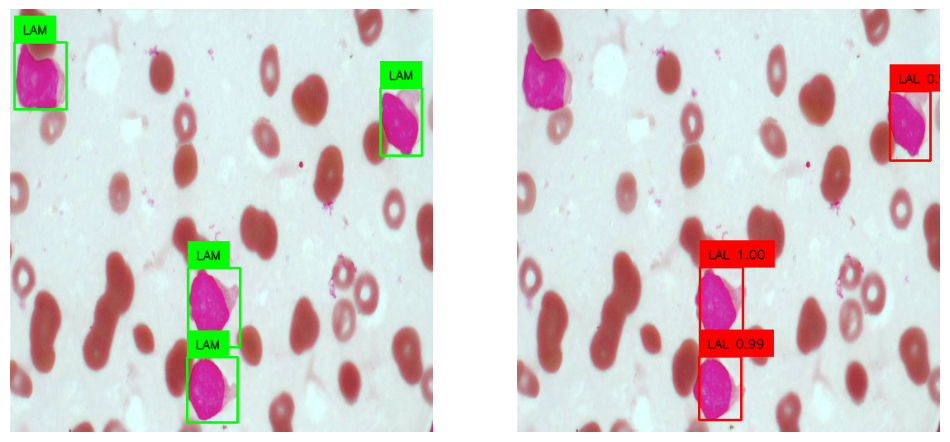

In [ ]:
real_annotation_color = sv.Color(0, 255, 0)
prediction_color = sv.Color(0, 0, 255)

model_predict_and_plot(5, VAL_DATASET,
                       sv.BoxAnnotator(color=real_annotation_color),
                       sv.BoxAnnotator(color=prediction_color),
                       id2label, image_processor, model, DEVICE, CONFIDENCE_TRESHOLD, IOU_TRESHOLD)

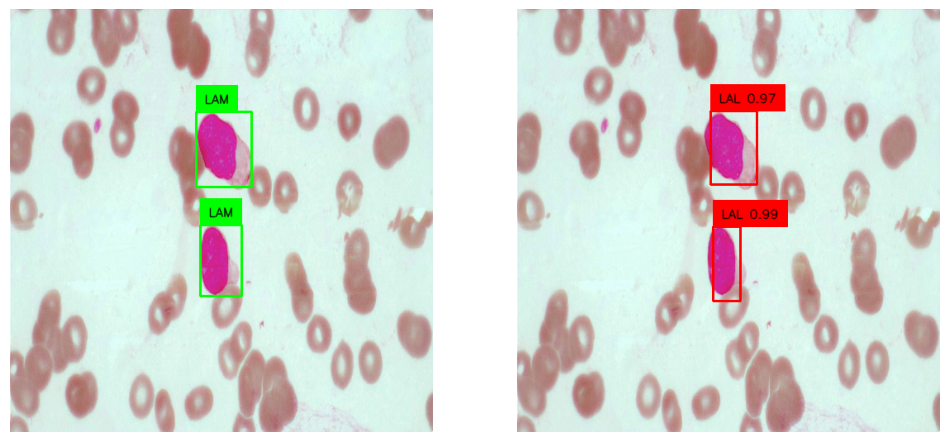

In [ ]:
real_annotation_color = sv.Color(0, 255, 0)
prediction_color = sv.Color(0, 0, 255)

model_predict_and_plot(2, VAL_DATASET,
                       sv.BoxAnnotator(color=real_annotation_color),
                       sv.BoxAnnotator(color=prediction_color),
                       id2label, image_processor, model, DEVICE, CONFIDENCE_TRESHOLD, IOU_TRESHOLD)

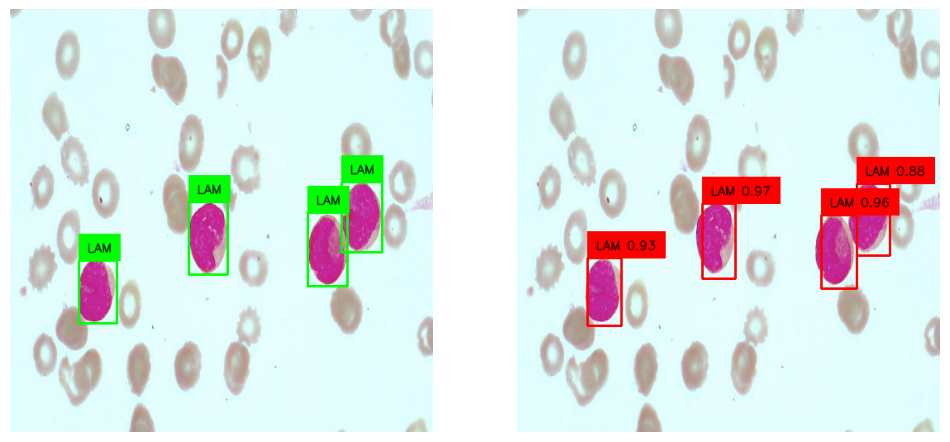

In [ ]:
real_annotation_color = sv.Color(0, 255, 0)
prediction_color = sv.Color(0, 0, 255)

model_predict_and_plot(6, VAL_DATASET,
                       sv.BoxAnnotator(color=real_annotation_color),
                       sv.BoxAnnotator(color=prediction_color),
                       id2label, image_processor, model, DEVICE, CONFIDENCE_TRESHOLD, IOU_TRESHOLD)

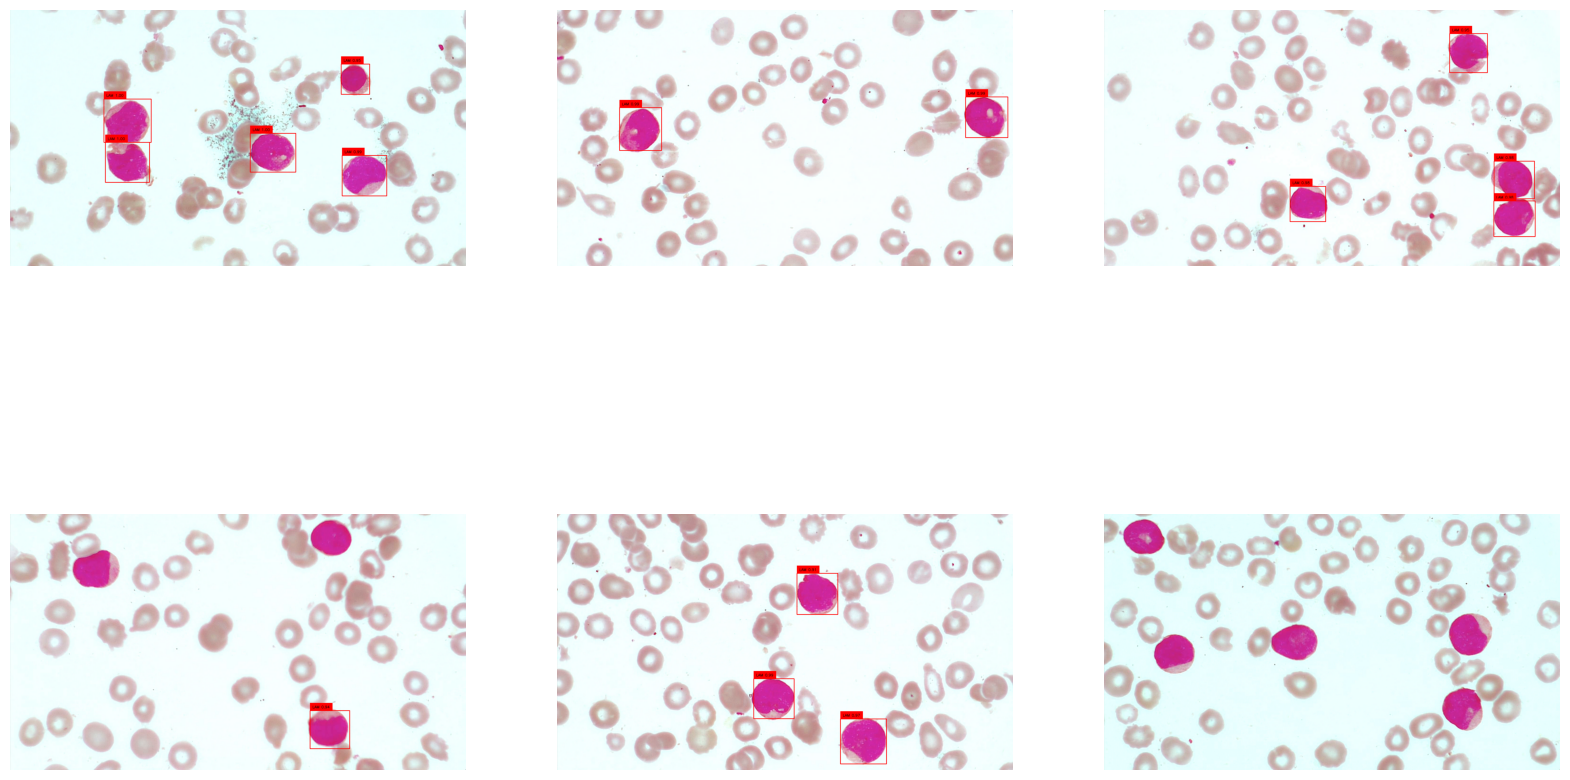

In [ ]:

real_annotation_color = sv.Color(0, 255, 0)
prediction_color = sv.Color(0, 0, 255)

image_ids =  [1,3,7, 4,5,6]
fig, axs = plt.subplots(2, 3, figsize=(20, 12))
for i, image_id in enumerate(image_ids):
    try:
      ax = axs[i // 3, i % 3]

      image, annotations = load_image_and_annotations(image_id,TRAIN_DATASET)


      frame1 = annotate_image(image.copy(), annotations, sv.BoxAnnotator(color=real_annotation_color), id2label)
      ax.imshow(frame1)
      ax.grid(False)
      ax.axis("off")

      # perform model inference and post-processing
      results = model_inference(image, image_processor, model, DEVICE, 0.9)

      # annotate image with model detection predictions
      frame2 = annotate_detections(image, results, sv.BoxAnnotator(color=prediction_color), id2label, IOU_TRESHOLD)
      ax.imshow(frame2)
      ax.grid(False)
      ax.axis("off")
    except Exception as e:
      continue

plt.show()

# Evaluation on Val Set

In [ ]:
!pip install -q coco_eval

  Preparing metadata (setup.py) ... done


In [ ]:
def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

def prepare_for_coco_detection(predictions):
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results

In [ ]:
dataset_test =CocoDetection(
    image_directory_path=VAL_DIRECTORY,
    image_processor=image_processor,
    train=False)
dataloader = DataLoader(dataset=dataset_test, collate_fn=collate_fn, batch_size=4)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [ ]:
print("Number of Test samples:", len(dataloader)*4)

Number of Test samples: 12


In [ ]:
from coco_eval import CocoEvaluator
from tqdm.notebook import tqdm

import numpy as np

evaluator = CocoEvaluator(coco_gt=dataset_test.coco, iou_types=["bbox"])

print("Running evaluation...")

for idx, batch in enumerate( dataloader):
    pixel_values = batch["pixel_values"].to(DEVICE)
    pixel_mask = batch["pixel_mask"].to(DEVICE)
    labels = [{k: v.to(DEVICE) for k, v in t.items()} for t in batch["labels"]]

    with torch.no_grad():
      outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = image_processor.post_process_object_detection(outputs , target_sizes=orig_target_sizes)

    predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
    predictions = prepare_for_coco_detection(predictions)
    evaluator.update(predictions)

evaluator.synchronize_between_processes()
evaluator.accumulate()
evaluator.summarize()

Running evaluation...
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.485
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.634
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.634
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.485
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.140
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.493
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.493
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Recall     (AR) @

In [ ]:

metrics = evaluator.coco_eval['bbox'].stats
metric_names = ['AP', 'AP50', 'AP75', 'APs', 'APm', 'APl']
metric_dict = {name: value for name, value in zip(metric_names, metrics)}
df = pd.DataFrame(metric_dict, index=[0])
df

,AP,AP50,AP75,APs,APm,APl
0,0.485182,0.633663,0.633663,-1.0,-1.0,0.485182


# Evaluation on Train Set

In [ ]:
dataset_test =CocoDetection(
    image_directory_path=TRAIN_DIRECTORY,
    image_processor=image_processor,
    train=False)
dataloader = DataLoader(dataset=dataset_test, collate_fn=collate_fn, batch_size=4)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [ ]:
print("Number of Test samples:", len(dataloader)*4)

Number of Test samples: 64


In [ ]:
from coco_eval import CocoEvaluator
from tqdm.notebook import tqdm

import numpy as np

evaluator = CocoEvaluator(coco_gt=dataset_test.coco, iou_types=["bbox"])

print("Running evaluation...")

for idx, batch in enumerate( dataloader):
    pixel_values = batch["pixel_values"].to(DEVICE)
    pixel_mask = batch["pixel_mask"].to(DEVICE)
    labels = [{k: v.to(DEVICE) for k, v in t.items()} for t in batch["labels"]]

    with torch.no_grad():
      outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = image_processor.post_process_object_detection(outputs , target_sizes=orig_target_sizes)

    predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
    predictions = prepare_for_coco_detection(predictions)
    evaluator.update(predictions)

evaluator.synchronize_between_processes()
evaluator.accumulate()
evaluator.summarize()

Running evaluation...
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.845
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.980
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.200
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.738
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.857
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.110
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.801
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.884
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.200
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.777
 Average Recall     (AR) @[ Io

In [ ]:

metrics = evaluator.coco_eval['bbox'].stats
metric_names = ['AP', 'AP50', 'AP75', 'APs', 'APm', 'APl']
metric_dict = {name: value for name, value in zip(metric_names, metrics)}
df = pd.DataFrame(metric_dict, index=[0])
df

,AP,AP50,AP75,APs,APm,APl
0,0.845476,0.988347,0.98033,0.2,0.73791,0.856729
